<a href="https://colab.research.google.com/github/LCaravaggio/ClaseTimeSeries/blob/main/Ejercicio4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
from google.colab import drive
import json

import requests
from requests.auth import HTTPBasicAuth

import pandas as pd

In [26]:
drive.mount('/content/drive', force_remount=True)
with open("/content/drive/My Drive/alphacast.json", 'r') as f:
    api_token= json.load(f)

Mounted at /content/drive


In [27]:
# Definir user key para la API
user_key = api_token["key"]

También es posible tomar dos series de un mismo dataset: 

In [28]:
# Merval y GGAL
ds='5816' # Equity Argentina
select1='71484' # GGAL
select2='71486' # Merval
equity = requests.get('https://api.alphacast.io/datasets/'+ds+'/data?apiKey='+user_key+'&%24select='+ select1 +'%2C'+ select2 + '&$format=csv', auth=HTTPBasicAuth(user_key, ''))
open('equity.csv','wb').write(equity.content)
equity = pd.read_csv('equity.csv',delimiter = ',')

In [29]:
equity=equity.dropna()

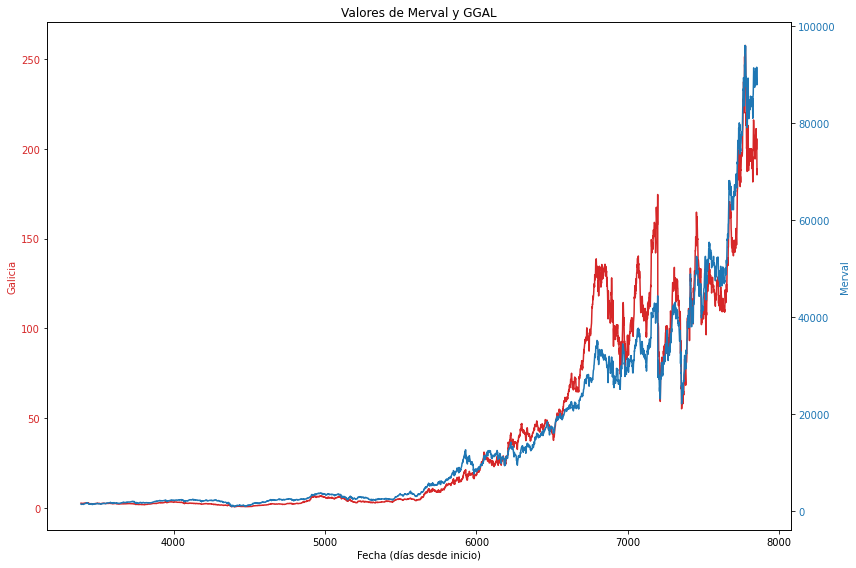

In [30]:
import matplotlib as mpl
%matplotlib inline
from matplotlib import pyplot as plt


mpl.rcParams['figure.figsize'] = (12,8)

time = equity.index

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Fecha (días desde inicio)')
ax1.set_ylabel('Galicia', color = color)
ax1.plot(time, equity.GGAL, color = color)
ax1.tick_params(axis = 'y', labelcolor = color)

ax2 = ax1.twinx()  

color = 'tab:blue'
ax2.set_ylabel('Merval', color = color) 
ax2.plot(time, equity.MERVAL, color = color)
ax2.tick_params(axis = 'y', labelcolor = color)

plt.title('Valores de Merval y GGAL')

fig.tight_layout()  
plt.show()

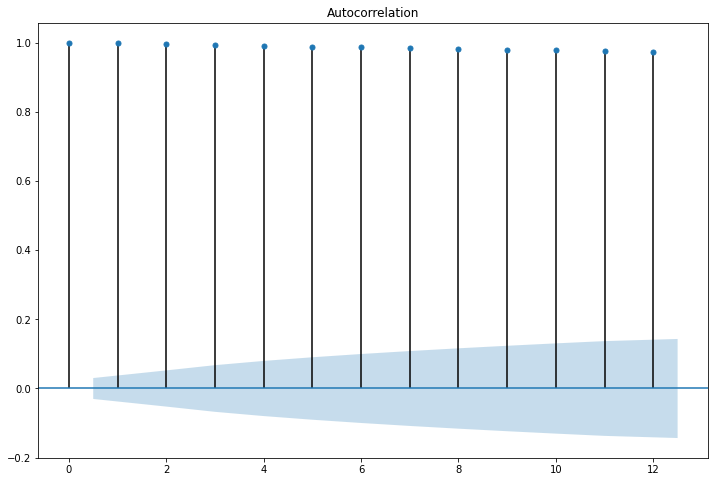

In [31]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

# Seteamos el tamaño del plot a 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# FAS con 12 lags
plot = plot_acf(equity.MERVAL, lags = 12)

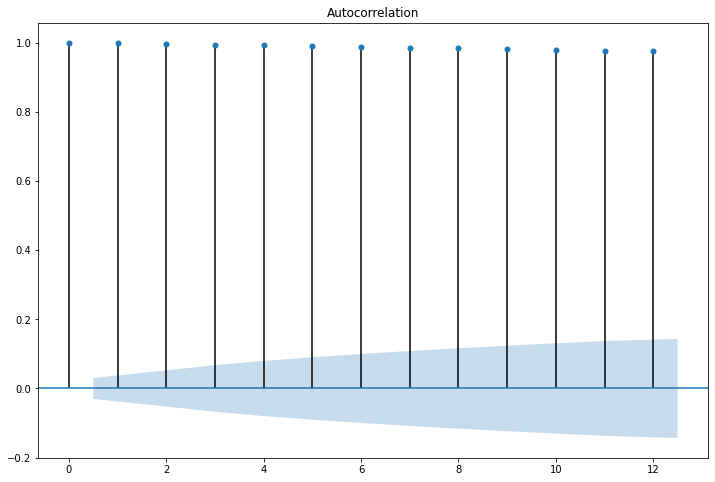

In [32]:
# Seteamos el tamaño del plot a 12x8
mpl.rcParams['figure.figsize'] = (12,8)

# FAS con 12 lags
plot = plot_acf(equity.GGAL, lags = 12)

In [33]:
# importamos el paquete para el test de Dickey-Fuller
from statsmodels.tsa.stattools import adfuller

# Corremos el ADF sin constante, con constante y con constante y ttendencia lineal
# GGAL
for i in ['nc', 'c', 'ct']:
    result = adfuller(equity.GGAL, regression = i)
    print('ADF Statistic with %s for GGAL price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

# Corremos el ADF sin constante, con constante y con constante y ttendencia lineal
# MERVAL
for i in ['nc', 'c', 'ct']:
    result = adfuller(equity.MERVAL, regression = i)
    print('ADF Statistic with %s for Merval level: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc for GGAL price: 0.473978
p-value: 0.818836

ADF Statistic with c for GGAL price: -0.288006
p-value: 0.927186

ADF Statistic with ct for GGAL price: -2.458751
p-value: 0.348882

ADF Statistic with nc for Merval level: 3.721574
p-value: 0.999999

ADF Statistic with c for Merval level: 2.872478
p-value: 1.000000

ADF Statistic with ct for Merval level: 0.855730
p-value: 1.000000



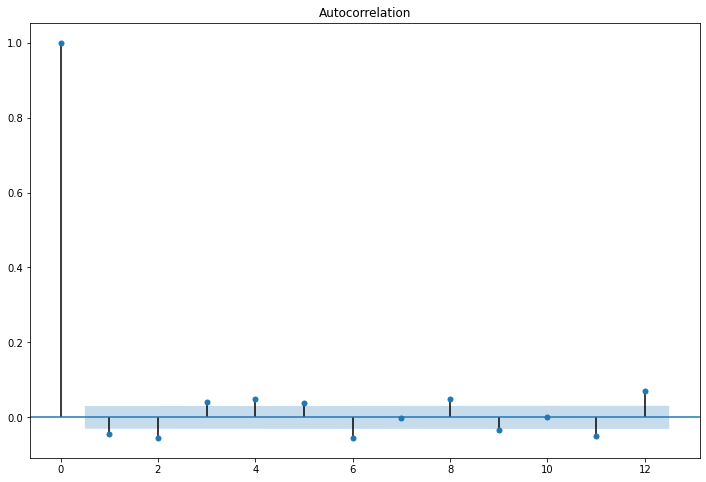

In [34]:
# Hacemos lo mismo que antes, pero sobre la primera diferencia
# GGAL

mpl.rcParams['figure.figsize'] = (12,8)
plot = plot_acf(equity.GGAL.diff().dropna(), lags = 12)

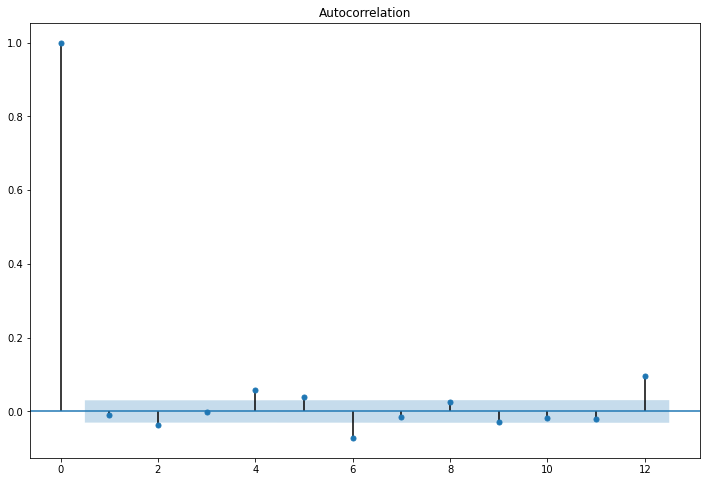

In [35]:
# Hacemos lo mismo que antes, pero sobre la primera diferencia
# Merval

mpl.rcParams['figure.figsize'] = (12,8)
plot = plot_acf(equity.MERVAL.diff().dropna(), lags = 12)

In [36]:
# También corremos los test de Dickey-Fuller
# GGAL
for i in ['nc', 'c', 'ct']:
    result = adfuller(equity.GGAL.diff().dropna(), regression = i)
    print('ADF Statistic with %s for Closing my_stock_train price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

# performs ADF tests with no constant, a constant, and a constant plus linear trend on differenced
# closing market level
for i in ['nc', 'c', 'ct']:
    result = adfuller(equity.MERVAL.diff().dropna(), regression = i)
    print('ADF Statistic with %s for Closing my_market_train level: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc for Closing my_stock_train price: -12.247608
p-value: 0.000000

ADF Statistic with c for Closing my_stock_train price: -12.303362
p-value: 0.000000

ADF Statistic with ct for Closing my_stock_train price: -12.360244
p-value: 0.000000

ADF Statistic with nc for Closing my_market_train level: -12.539924
p-value: 0.000000

ADF Statistic with c for Closing my_market_train level: -12.768637
p-value: 0.000000

ADF Statistic with ct for Closing my_market_train level: -13.105732
p-value: 0.000000



Podríamos correr el modelo en nivel, el ajuste será bueno, pero se trata de una regresión espuria

In [37]:
# importamos la librería para correr el modelo
import statsmodels.api as sm

# agregamos un término constante
equity = sm.add_constant(equity)

# estimamos la regresión lineal
lr_model = sm.OLS(equity.MERVAL, equity[['const', 'GGAL']])
lr_model_fit = lr_model.fit(cov_type='HC0')

# imprimimos los resultados
print(lr_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                 MERVAL   R-squared:                       0.947
Model:                            OLS   Adj. R-squared:                  0.947
Method:                 Least Squares   F-statistic:                 1.967e+04
Date:                Thu, 10 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:17:55   Log-Likelihood:                -41323.
No. Observations:                4197   AIC:                         8.265e+04
Df Residuals:                    4195   BIC:                         8.266e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        801.5378     48.441     16.547      0.0

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/tsatools.py:117: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


La solución sería diferenciar las variables, pero se trata de un modelo poco útil ya que la predicción la realiza sobre un dato contemporáneo. 

In [38]:
# adds a constant term
equity['GGAL_d']=equity.GGAL.diff()
equity['MERVAL_d']=equity.MERVAL.diff()
equity=equity.dropna()

# estimates a linear regression of the closing share price on the lagged closing market level
lr_model = sm.OLS(equity.MERVAL_d, equity[['const', 'GGAL_d']])
lr_model_fit = lr_model.fit(cov_type='HC0')

# prints a summary
print(lr_model_fit.summary())

                            OLS Regression Results                            
Dep. Variable:               MERVAL_d   R-squared:                       0.812
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     2019.
Date:                Thu, 10 Mar 2022   Prob (F-statistic):               0.00
Time:                        16:17:55   Log-Likelihood:                -29484.
No. Observations:                4196   AIC:                         5.897e+04
Df Residuals:                    4194   BIC:                         5.899e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         10.9490      4.223      2.593      0.0

In [39]:
for i in ['nc', 'c', 'ct']:
    result = adfuller(lr_model_fit.resid, regression = i)
    print('ADF Statistic with %s for Closing my_stock_train price: %f' % (i, result[0]))
    print('p-value: %f' % result[1])
    print('')

ADF Statistic with nc for Closing my_stock_train price: -18.734247
p-value: 0.000000

ADF Statistic with c for Closing my_stock_train price: -18.731891
p-value: 0.000000

ADF Statistic with ct for Closing my_stock_train price: -19.150451
p-value: 0.000000



Para que la predicción tenga sentido tendríamos que utilizar las variables rezagadas, con lo que el poder predictivo obviamente se reduce mucho. 

In [40]:
# adds 3 month lags for the market
for i in range(1, 4):
    new_col = 'MERVAL_l' + str(i)
    equity[new_col] = equity.MERVAL.shift(i)
    
# adds 3 month lags for the stock price
for i in range(1, 4):
    new_col = 'GGAL_l' + str(i)
    equity[new_col] = equity.GGAL.shift(i)

In [41]:
# attaches the residuals to the training data set and shifts them down be one to get them alligned properly to be the
# lagged residuals of the linear model in the ECM
equity['disequilibrium'] = lr_model_fit.resid
equity.disequilibrium = equity.disequilibrium.shift(1)

equity_copia = equity.copy()


# for i in the list of columns I want to difference...
for i in ['GGAL', 'GGAL_l1', 'GGAL_l2', 'GGAL_l3', 'MERVAL_l1', 'MERVAL_l2', 'MERVAL_l3']:
    # difference column i
    equity_copia[i] = equity_copia[i].diff()

# drop the first row because you lose a row when differencing; you can't difference a row without a prior observation
equity_copia= equity_copia.dropna()

# creates a list of predictors for easy referencing
predictors = ['GGAL_l1', 'GGAL_l2', 'GGAL_l3', 
              'MERVAL_l1', 'MERVAL_l2', 'MERVAL_l3', 
             'disequilibrium', 'const']


# estimates a linear regression of the closing share price on the lagged closing market level
ecm = sm.OLS(equity_copia.GGAL, equity_copia[predictors])
ecm_fit = ecm.fit(cov_type='HC0')

# prints a summary
print(ecm_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   GGAL   R-squared:                       0.009
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     1.526
Date:                Thu, 10 Mar 2022   Prob (F-statistic):              0.153
Time:                        16:17:56   Log-Likelihood:                -9912.6
No. Observations:                4192   AIC:                         1.984e+04
Df Residuals:                    4185   BIC:                         1.988e+04
Df Model:                           6                                         
Covariance Type:                  HC0                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
GGAL_l1           -0.0027      0.002     -1.